In [4]:
import pandas as pd
import numpy as np
import pymongo
import streamlit as st

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 5]

In [5]:
from load_coin_history import get_coin_daily_history

In [6]:
data = get_coin_daily_history('bitcoin', 'max')

In [7]:
print(data.size)
data.head()

14524


,timestamp,price,market_cap,total_volume
0,1367107200000,135.30,1.500518e+09,0.0
1,1367193600000,141.96,1.575032e+09,0.0
2,1367280000000,135.30,1.501657e+09,0.0
3,1367366400000,117.00,1.298952e+09,0.0
4,1367452800000,103.43,1.148668e+09,0.0


In [8]:
bitcoin_market_data = data.copy()

In [9]:
convert_dict = {'timestamp': 'datetime64[ms]',
                'price': float,
                'market_cap': float,
                'total_volume': float
                }
 
bitcoin_market_data = bitcoin_market_data.astype(convert_dict)
print(bitcoin_market_data.dtypes)

timestamp       datetime64[ns]
price                  float64
market_cap             float64
total_volume           float64
dtype: object


In [10]:
bitcoin_market_data['marketcap_in_bilions'] = bitcoin_market_data['market_cap']/1000000000

<AxesSubplot:xlabel='timestamp'>

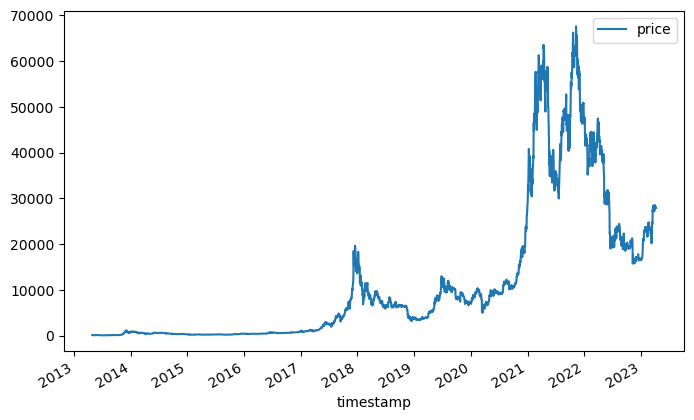

In [11]:
bitcoin_market_data.plot(y = 'price', x = 'timestamp')

<AxesSubplot:xlabel='timestamp'>

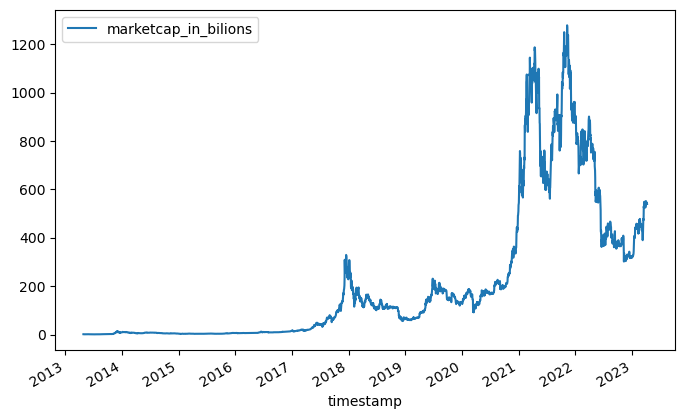

In [12]:
bitcoin_market_data.plot(y = 'marketcap_in_bilions', x = 'timestamp')

<AxesSubplot:xlabel='timestamp'>

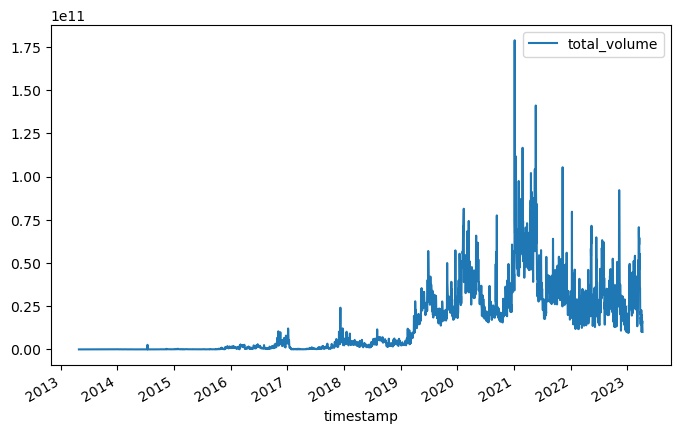

In [13]:
bitcoin_market_data.plot(y = 'total_volume', x = 'timestamp')

In [14]:
bitcoin_market_data.tail()

,timestamp,price,market_cap,total_volume,marketcap_in_bilions
3626,2023-04-04,27815.426531,5.393509e+11,1.971149e+10,539.350909
3627,2023-04-05,28175.330334,5.443136e+11,1.487161e+10,544.313568
3628,2023-04-06,28197.200341,5.454098e+11,1.650762e+10,545.409755
3629,2023-04-07,28042.983386,5.426012e+11,1.307953e+10,542.601176
3630,2023-04-08,27934.438713,5.404324e+11,1.014128e+10,540.432354


In [15]:
bitcoin_market_data[bitcoin_market_data.market_cap.isnull()]

,timestamp,price,market_cap,total_volume,marketcap_in_bilions
1433,2017-04-02,1098.068,NaN,8.023151e+07,NaN


In [16]:
bitcoin_market_data.sort_values(by='timestamp', ascending=True, inplace=True)

In [17]:
bitcoin_market_data['marketcap_in_bilions'] = bitcoin_market_data['marketcap_in_bilions'].fillna((bitcoin_market_data['marketcap_in_bilions'].ffill() + bitcoin_market_data['marketcap_in_bilions'].bfill()) /2)

In [18]:
bitcoin_train = bitcoin_market_data[bitcoin_market_data['timestamp'] < pd.to_datetime('2022-06-01')]

In [19]:
bitcoin_valid = bitcoin_market_data[(bitcoin_market_data['timestamp'] >= pd.to_datetime('2022-06-01')) & (bitcoin_market_data['timestamp'] < pd.to_datetime('2023-01-01'))]

In [20]:
bitcoin_test = bitcoin_market_data[bitcoin_market_data['timestamp'] >= pd.to_datetime('2023-01-01')]

In [21]:
print("bitcoin_market_data = ",bitcoin_market_data.shape)
print("bitcoin_train = ",bitcoin_train.shape)
print("bitcoin_valid = ",bitcoin_valid.shape)
print("bitcoin_test = ",bitcoin_test.shape)

bitcoin_market_data =  (3631, 5)
bitcoin_train =  (3319, 5)
bitcoin_valid =  (214, 5)
bitcoin_test =  (98, 5)


In [22]:
bitcoin_train.head()

,timestamp,price,market_cap,total_volume,marketcap_in_bilions
0,2013-04-28,135.30,1.500518e+09,0.0,1.500518
1,2013-04-29,141.96,1.575032e+09,0.0,1.575032
2,2013-04-30,135.30,1.501657e+09,0.0,1.501657
3,2013-05-01,117.00,1.298952e+09,0.0,1.298952
4,2013-05-02,103.43,1.148668e+09,0.0,1.148668


In [23]:
arbitcoin_train = np.array(bitcoin_train[['price', 'total_volume', 'marketcap_in_bilions']])
arbitcoin_valid = np.array(bitcoin_valid[['price', 'total_volume', 'marketcap_in_bilions']])
arbitcoin_test = np.array(bitcoin_test[['price', 'total_volume', 'marketcap_in_bilions']])

In [24]:
arbitcoin_train[0,:]

array([135.3       ,   0.        ,   1.50051759])

In [25]:
def create_sequences(data, seq_len):
    X = []
    y = []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len, :])
        y.append(data[i+seq_len, :])
    return np.array(X), np.array(y)

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object to scale the data to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform the training, validation, and test data
train_data = scaler.fit_transform(arbitcoin_train)
val_data = scaler.transform(arbitcoin_valid)
test_data = scaler.transform(arbitcoin_test)

In [27]:
seq_len = 30   # Use 30 days of data to predict the next day

# Create input sequences for training, validation, and test sets
train_X, train_y = create_sequences(train_data, seq_len)
val_X, val_y = create_sequences(val_data, seq_len)

test_X, test_y = create_sequences(test_data, seq_len)

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [29]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(seq_len, 3)))
model.add(Dense(3))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [30]:
model.fit(train_X, train_y, epochs=50, batch_size=33, validation_data=(val_X, val_y))

Epoch 1/50
100/100 [==============================] - 2s 10ms/step - loss: 0.0215 - val_loss: 0.0049
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 8.8660e-04 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 8.2410e-04 - val_loss: 0.0018
Epoch 7/50
100/100 [==============================] - 1s 8ms/step - loss: 7.5150e-04 - val_loss: 0.0018
Epoch 8/50
100/100 [==============================] - 1s 8ms/step - loss: 7.2466e-04 - val_loss: 0.0018
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 7.0092e-04 - val_loss: 0.0017
Epoch 10/50
100/100 [==============================] - 1s 8ms/step - loss: 6.8

In [31]:
test_loss = model.evaluate(test_X, test_y)

3/3 [==============================] - 0s 8ms/step - loss: 0.0013


In [32]:
test_pred = model.predict(test_X)

3/3 [==============================] - 0s 4ms/step


In [74]:
test_X.shape

(68, 30, 3)

In [89]:
def create_sequences_x(data, seq_len):
    X = []
    for i in range(len(data)-seq_len + 1):
        X.append(data[i:i+seq_len, :])
    return np.array(X)

In [93]:
newX = create_sequences_x(test_pred[-30:,:], 30)

In [87]:
for i in range(1):
    print(i)

0


In [95]:
model.predict(newX)

1/1 [==============================] - 0s 31ms/step


array([[0.4195362 , 0.11302653, 0.41705498]], dtype=float32)

In [82]:
test_pred[38:,:]

array([[0.33366963, 0.14458342, 0.3285131 ],
       [0.32546076, 0.16658539, 0.3184764 ],
       [0.31915104, 0.20111424, 0.31291428],
       [0.31330457, 0.2054403 , 0.3081822 ],
       [0.3177171 , 0.20877469, 0.31576315],
       [0.3337164 , 0.2591823 , 0.338178  ],
       [0.34520492, 0.29810113, 0.35230497],
       [0.3500737 , 0.31262505, 0.35566399],
       [0.35804394, 0.31882125, 0.36223957],
       [0.37687048, 0.32837626, 0.3823012 ],
       [0.38483492, 0.30438218, 0.3878986 ],
       [0.39849174, 0.28960457, 0.40198645],
       [0.40636572, 0.29272053, 0.40905514],
       [0.41105315, 0.26172927, 0.41338804],
       [0.4112979 , 0.24234584, 0.41099414],
       [0.41588345, 0.205383  , 0.41610196],
       [0.41520873, 0.18112865, 0.4132627 ],
       [0.41485474, 0.1541075 , 0.41253287],
       [0.41698852, 0.13478506, 0.41523924],
       [0.4140555 , 0.12672204, 0.41089532],
       [0.41261426, 0.12027972, 0.40979227],
       [0.41760483, 0.12200413, 0.41715983],
       [0.

In [36]:
test_pred_transformed = scaler.inverse_transform(test_pred)

In [37]:
test_pred_transformed.shape

(68, 3)

In [38]:
bitcoin_test.reset_index().iloc[30:,:]

,index,timestamp,price,market_cap,total_volume,marketcap_in_bilions
30,3563,2023-01-31,22840.385859,4.392957e+11,3.859460e+10,439.295731
31,3564,2023-02-01,23137.323554,4.459912e+11,3.268364e+10,445.991168
32,3565,2023-02-02,23725.161796,4.573831e+11,3.745206e+10,457.383099
33,3566,2023-02-03,23539.676770,4.535650e+11,4.473530e+10,453.565019
34,3567,2023-02-04,23451.577651,4.523126e+11,4.126704e+10,452.312596
...,...,...,...,...,...,...
93,3626,2023-04-04,27815.426531,5.393509e+11,1.971149e+10,539.350909
94,3627,2023-04-05,28175.330334,5.443136e+11,1.487161e+10,544.313568
95,3628,2023-04-06,28197.200341,5.454098e+11,1.650762e+10,545.409755
96,3629,2023-04-07,28042.983386,5.426012e+11,1.307953e+10,542.601176


In [39]:
df_test_pred = pd.DataFrame(test_pred_transformed, columns = ['pred_price', 'pred_total_volume', 'pred_marketcap_in_bilions'])

In [40]:
df_test_pred_summ = pd.concat([bitcoin_test.reset_index().iloc[30:,:].reset_index(), df_test_pred.reset_index()] , axis = 1)

In [41]:
df_test_pred_summ = df_test_pred_summ[["timestamp", "price", "total_volume", "marketcap_in_bilions", "pred_price", "pred_total_volume", "pred_marketcap_in_bilions"]]

<AxesSubplot:xlabel='timestamp'>

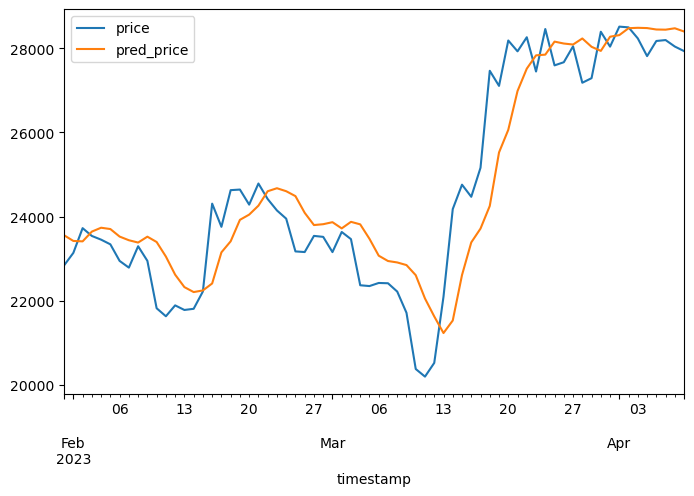

In [42]:
df_test_pred_summ.plot(x="timestamp", y=["price", "pred_price"], kind="line")

In [43]:
df_test_pred_summ1 = df_test_pred_summ[["timestamp","pred_price", "pred_total_volume", "pred_marketcap_in_bilions"]]
bitcoin_market_data_with_pred = bitcoin_market_data.merge(df_test_pred_summ1, how='left', on='timestamp')

<AxesSubplot:xlabel='timestamp'>

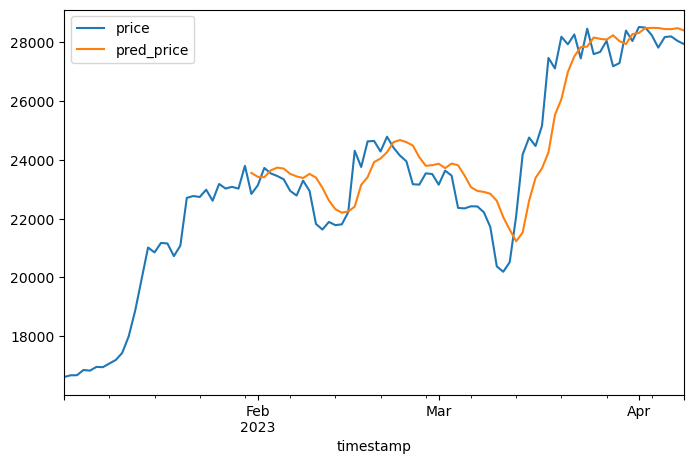

In [44]:
bitcoin_market_data_with_pred[bitcoin_market_data['timestamp'] > pd.to_datetime('2023-01-01')].plot(x="timestamp", y=["price", "pred_price"], kind="line")

In [59]:
test_X[-1,:,:]

array([[0.32043074, 0.15927321, 0.32778945],
       [0.30064766, 0.22456772, 0.30677799],
       [0.29796679, 0.2884047 , 0.30471268],
       [0.30279774, 0.21100003, 0.3082654 ],
       [0.3261016 , 0.2048134 , 0.33257949],
       [0.35694196, 0.37340064, 0.36441938],
       [0.36552548, 0.39528641, 0.3737283 ],
       [0.36126365, 0.35276428, 0.36936806],
       [0.3714842 , 0.33924019, 0.37996412],
       [0.40561348, 0.36120603, 0.41412822],
       [0.40030053, 0.25978307, 0.40882634],
       [0.41627482, 0.2593421 , 0.42715033],
       [0.41246019, 0.30921064, 0.42108988],
       [0.4174206 , 0.19246546, 0.42655301],
       [0.40535555, 0.19785359, 0.4145014 ],
       [0.42031472, 0.11381488, 0.42941756],
       [0.40752049, 0.12046946, 0.41694196],
       [0.40862642, 0.08414899, 0.41797993],
       [0.41422635, 0.08077615, 0.42401643],
       [0.40140354, 0.10351966, 0.41036669],
       [0.40301792, 0.09870927, 0.41256688],
       [0.41935635, 0.11793345, 0.42881505],
       [0.

In [51]:
test_pred

array([[0.34772   , 0.19534248, 0.34808496],
       [0.34572324, 0.20074165, 0.34492216],
       [0.34557083, 0.19655406, 0.34477678],
       [0.34901264, 0.2017275 , 0.3491637 ],
       [0.35037544, 0.21628596, 0.35073268],
       [0.34990898, 0.22124337, 0.3501679 ],
       [0.34726033, 0.19322431, 0.34591937],
       [0.3459715 , 0.18233456, 0.34281388],
       [0.3451552 , 0.18493585, 0.34159756],
       [0.34722784, 0.19475895, 0.34518212],
       [0.3453479 , 0.19440162, 0.34313977],
       [0.34022847, 0.22045545, 0.33656472],
       [0.333854  , 0.22560883, 0.32996953],
       [0.32947296, 0.20088619, 0.32488033],
       [0.32772717, 0.18707135, 0.32240525],
       [0.32830226, 0.19304346, 0.32366866],
       [0.3307576 , 0.21064076, 0.32825997],
       [0.341705  , 0.22336966, 0.34430876],
       [0.34559682, 0.23761168, 0.348664  ],
       [0.35315016, 0.2583756 , 0.3582502 ],
       [0.35499117, 0.22516286, 0.3584222 ],
       [0.35813543, 0.21634771, 0.35938635],
       [0.

In [58]:
test_data[-10:,:]

array([[0.41935635, 0.11793345, 0.42881505],
       [0.41411758, 0.12690489, 0.42377712],
       [0.42115929, 0.10683611, 0.43108328],
       [0.42089518, 0.05637627, 0.43049064],
       [0.41701008, 0.06530611, 0.4259771 ],
       [0.41077637, 0.11018528, 0.42141499],
       [0.41610439, 0.08313084, 0.42529806],
       [0.41642815, 0.09227594, 0.42615578],
       [0.41414512, 0.07311326, 0.42395819],
       [0.41253822, 0.05668873, 0.42226118]])

In [61]:
test_X[-1,:,:]

array([[0.32043074, 0.15927321, 0.32778945],
       [0.30064766, 0.22456772, 0.30677799],
       [0.29796679, 0.2884047 , 0.30471268],
       [0.30279774, 0.21100003, 0.3082654 ],
       [0.3261016 , 0.2048134 , 0.33257949],
       [0.35694196, 0.37340064, 0.36441938],
       [0.36552548, 0.39528641, 0.3737283 ],
       [0.36126365, 0.35276428, 0.36936806],
       [0.3714842 , 0.33924019, 0.37996412],
       [0.40561348, 0.36120603, 0.41412822],
       [0.40030053, 0.25978307, 0.40882634],
       [0.41627482, 0.2593421 , 0.42715033],
       [0.41246019, 0.30921064, 0.42108988],
       [0.4174206 , 0.19246546, 0.42655301],
       [0.40535555, 0.19785359, 0.4145014 ],
       [0.42031472, 0.11381488, 0.42941756],
       [0.40752049, 0.12046946, 0.41694196],
       [0.40862642, 0.08414899, 0.41797993],
       [0.41422635, 0.08077615, 0.42401643],
       [0.40140354, 0.10351966, 0.41036669],
       [0.40301792, 0.09870927, 0.41256688],
       [0.41935635, 0.11793345, 0.42881505],
       [0.

In [64]:
test_y[-1,:]

array([0.41253822, 0.05668873, 0.42226118])

In [66]:
test_y.shape

(68, 3)

In [69]:

bitcoin_market_data_with_pred


,timestamp,price,market_cap,total_volume,marketcap_in_bilions,pred_price,pred_total_volume,pred_marketcap_in_bilions
0,2013-04-28,135.300000,1.500518e+09,0.000000e+00,1.500518,NaN,NaN,NaN
1,2013-04-29,141.960000,1.575032e+09,0.000000e+00,1.575032,NaN,NaN,NaN
2,2013-04-30,135.300000,1.501657e+09,0.000000e+00,1.501657,NaN,NaN,NaN
3,2013-05-01,117.000000,1.298952e+09,0.000000e+00,1.298952,NaN,NaN,NaN
4,2013-05-02,103.430000,1.148668e+09,0.000000e+00,1.148668,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3626,2023-04-04,27815.426531,5.393509e+11,1.971149e+10,539.350909,28482.191406,1.760639e+10,536.854370
3627,2023-04-05,28175.330334,5.443136e+11,1.487161e+10,544.313568,28448.457031,1.861726e+10,534.735901
3628,2023-04-06,28197.200341,5.454098e+11,1.650762e+10,545.409755,28444.201172,1.805652e+10,535.404968
3629,2023-04-07,28042.983386,5.426012e+11,1.307953e+10,542.601176,28477.207031,1.816964e+10,535.857544


In [70]:
test_pred[-1,:]

array([0.41943917, 0.09662998, 0.41713557], dtype=float32)

In [73]:
scaler.inverse_transform(test_pred[-2:,:])

array([[2.8477207e+04, 1.8169641e+10, 5.3585754e+02],
       [2.8400592e+04, 1.7286531e+10, 5.3388165e+02]], dtype=float32)

In [72]:
test_pred

array([[0.34772   , 0.19534248, 0.34808496],
       [0.34572324, 0.20074165, 0.34492216],
       [0.34557083, 0.19655406, 0.34477678],
       [0.34901264, 0.2017275 , 0.3491637 ],
       [0.35037544, 0.21628596, 0.35073268],
       [0.34990898, 0.22124337, 0.3501679 ],
       [0.34726033, 0.19322431, 0.34591937],
       [0.3459715 , 0.18233456, 0.34281388],
       [0.3451552 , 0.18493585, 0.34159756],
       [0.34722784, 0.19475895, 0.34518212],
       [0.3453479 , 0.19440162, 0.34313977],
       [0.34022847, 0.22045545, 0.33656472],
       [0.333854  , 0.22560883, 0.32996953],
       [0.32947296, 0.20088619, 0.32488033],
       [0.32772717, 0.18707135, 0.32240525],
       [0.32830226, 0.19304346, 0.32366866],
       [0.3307576 , 0.21064076, 0.32825997],
       [0.341705  , 0.22336966, 0.34430876],
       [0.34559682, 0.23761168, 0.348664  ],
       [0.35315016, 0.2583756 , 0.3582502 ],
       [0.35499117, 0.22516286, 0.3584222 ],
       [0.35813543, 0.21634771, 0.35938635],
       [0.